In [99]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,  GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [100]:
main_dir = "D:\\Competitions\\DataStorm-Final-2021"
data_dir = os.path.join(main_dir,"data\\Data\\")
logs_dir = os.path.join(main_dir,"logs\\")
scripts_dir = os.path.join(main_dir,"src\\scripts\\")
model_dir = os.path.join(main_dir,"src\\models\\")
feature_dir = os.path.join(data_dir,"feature\\")

In [101]:
train_df = pd.read_csv(feature_dir+'final4.csv').sample(frac=1)
test_df = train_df.loc[train_df['month_rank'] == 19]

In [102]:
X_tr, y_tr = train_df.iloc[:, :-1], train_df.iloc[:,-1]
X_test = test_df.copy()
X, X_val, y, y_val = train_test_split(X_tr, y_tr, random_state=443, test_size=0.2, shuffle=False)

In [103]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
SEED = 443 
NFOLDS = 5 
kf = KFold(n_splits=NFOLDS, random_state=SEED,shuffle=True)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [104]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    i=0
    for train_index, test_index in kf.split(x_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        i+=1

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [105]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_val)
        if self.metric == 'acc':
            return accuracy_score(y_val, preds)
        else:
            return roc_auc_score(y_val, preds, average='macro')
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params

In [106]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
rf_params = optimizer.optimize()
rf_params['random_state'] = 666

[I 2021-03-27 20:16:57,457] A new study created in memory with name: no-name-e2d1d7af-ca83-4044-b27e-69c9b5e742f9
[I 2021-03-27 20:16:58,182] Trial 0 finished with value: 0.8397226890756303 and parameters: {'max_depth': 6, 'n_estimators': 132, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8397226890756303.
[I 2021-03-27 20:16:58,389] Trial 1 finished with value: 0.823966386554622 and parameters: {'max_depth': 3, 'n_estimators': 93, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8397226890756303.
[I 2021-03-27 20:16:58,448] Trial 2 finished with value: 0.835873949579832 and parameters: {'max_depth': 6, 'n_estimators': 16, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8397226890756303.
[I 2021-03-27 20:16:58,571] Trial 3 finished with value: 0.8119159663865547 and parameters: {'max_depth': 2, 'n_estimators': 48, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8397226890756303.
[I 2021-03-27 20:16:59,151] Trial 4 finished with value: 0.823764705882353 and para

In [107]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
et_params = optimizer.optimize()
et_params['random_state'] = 666

[I 2021-03-27 20:17:03,746] A new study created in memory with name: no-name-cf4b16d0-7e54-4a0c-8923-95e744d9321c
[I 2021-03-27 20:17:03,939] Trial 0 finished with value: 0.6941008403361344 and parameters: {'n_estimators': 132, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6941008403361344.
[I 2021-03-27 20:17:04,112] Trial 1 finished with value: 0.7204033613445378 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7204033613445378.
[I 2021-03-27 20:17:04,146] Trial 2 finished with value: 0.6472857142857142 and parameters: {'n_estimators': 16, 'max_depth': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7204033613445378.
[I 2021-03-27 20:17:04,220] Trial 3 finished with value: 0.6924957983193278 and parameters: {'n_estimators': 48, 'max_depth': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7204033613445378.
[I 2021-03-27 20:17:04,458] Trial 4 finished with value: 0.7144537815126049 and p

In [108]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
abc_params = optimizer.optimize()
abc_params['random_state'] = 666

[I 2021-03-27 20:17:08,173] A new study created in memory with name: no-name-08263a50-da97-413f-94db-4e1134fc37e9
[I 2021-03-27 20:17:08,859] Trial 0 finished with value: 0.88309243697479 and parameters: {'n_estimators': 132, 'learning_rate': 0.8442645495290093}. Best is trial 0 with value: 0.88309243697479.
[I 2021-03-27 20:17:09,121] Trial 1 finished with value: 0.8768403361344538 and parameters: {'n_estimators': 64, 'learning_rate': 0.12941235380242858}. Best is trial 0 with value: 0.88309243697479.
[I 2021-03-27 20:17:09,508] Trial 2 finished with value: 0.8758403361344538 and parameters: {'n_estimators': 93, 'learning_rate': 0.2447206803141601}. Best is trial 0 with value: 0.88309243697479.
[I 2021-03-27 20:17:09,754] Trial 3 finished with value: 0.8068067226890756 and parameters: {'n_estimators': 62, 'learning_rate': 0.049288387403100035}. Best is trial 0 with value: 0.88309243697479.
[I 2021-03-27 20:17:09,824] Trial 4 finished with value: 0.8768403361344538 and parameters: {'n_

In [109]:
def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    model = GradientBoostingClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
gbc_params = optimizer.optimize()
gbc_params['random_state'] = 666

[I 2021-03-27 20:17:19,967] A new study created in memory with name: no-name-76ad6594-d95b-4ef4-bcab-74ebb929e6ef
[I 2021-03-27 20:17:20,043] Trial 0 finished with value: 0.8725378151260506 and parameters: {'n_estimators': 12, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8725378151260506.
[I 2021-03-27 20:17:20,658] Trial 1 finished with value: 0.8816890756302522 and parameters: {'n_estimators': 71, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8816890756302522.
[I 2021-03-27 20:17:21,405] Trial 2 finished with value: 0.876638655462185 and parameters: {'n_estimators': 70, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8816890756302522.
[I 2021-03-27 20:17:21,684] Trial 3 finished with value: 0.8851428571428572 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.8851428571428572.
[I 2021-03-27 20:17:22,063] Trial 4 finished with value: 0.8858907563025211 and par

In [110]:
def create_model(trial):
    kernel = trial.suggest_categorical("kernel", ["rbf"])  
    #"linear", "poly", 
    #gamma = trial.suggest_loguniform("gamma", 1e-1, 1)
    c = trial.suggest_uniform("C", 1e-1, 1)
    model = SVC(
        kernel=kernel,
        #gamma=gamma,
        C=c,
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
svc_params = optimizer.optimize()
svc_params['random_state'] = 666

[I 2021-03-27 20:17:32,396] A new study created in memory with name: no-name-6d1b17c9-c382-4079-a9b3-757088701aa9
[I 2021-03-27 20:17:33,290] Trial 0 finished with value: 0.5623277310924369 and parameters: {'kernel': 'rbf', 'C': 0.7303934096720512}. Best is trial 0 with value: 0.5623277310924369.
[I 2021-03-27 20:17:34,188] Trial 1 finished with value: 0.5613277310924369 and parameters: {'kernel': 'rbf', 'C': 0.8597679785653911}. Best is trial 0 with value: 0.5623277310924369.
[I 2021-03-27 20:17:35,033] Trial 2 finished with value: 0.5602268907563025 and parameters: {'kernel': 'rbf', 'C': 0.7088629023438628}. Best is trial 0 with value: 0.5623277310924369.
[I 2021-03-27 20:17:35,885] Trial 3 finished with value: 0.5623277310924369 and parameters: {'kernel': 'rbf', 'C': 0.7550722515232674}. Best is trial 0 with value: 0.5623277310924369.
[I 2021-03-27 20:17:36,739] Trial 4 finished with value: 0.5644285714285714 and parameters: {'kernel': 'rbf', 'C': 0.9563121617017054}. Best is trial 

In [111]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=abc_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gbc_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [112]:
y_train = y_tr.values
x_train = X_tr.values
x_test = X_test.iloc[:,1:].values

In [113]:
x_test

array([[-2.09757366e-02,  3.35611030e-01, -2.10090145e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.09757366e-02, -1.98881635e-01,  1.86655126e-02, ...,
         3.10000000e+01,  1.29166667e-01,  1.00000000e+00],
       [-2.09757366e-02,  3.35611030e-01,  1.86655126e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.88561422e-02, -1.98881635e-01,  1.86655126e-02, ...,
         2.80000000e+01,  1.29629630e-01,  1.00000000e+00],
       [-1.37586327e-01,  3.35611030e-01,  1.86655126e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.09757366e-02, -1.98881635e-01,  1.86655126e-02, ...,
         8.00000000e+00,  3.70370370e-02,  1.00000000e+00]])

In [114]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)
print("Training is complete")

Training is complete


In [115]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.01252279 0.00554394 0.01154823 0.00193681 0.00153643 0.02495536
 0.03603957 0.01113649 0.66463964 0.00666839 0.01666388 0.00882542
 0.01193998 0.00194432 0.027648   0.0854032  0.07104753]
[0.01646427 0.03011096 0.09735779 0.00813007 0.00583162 0.01227185
 0.01136412 0.09049766 0.2818262  0.03575374 0.04476246 0.00579054
 0.00430538 0.00316753 0.03770629 0.15783978 0.15681973]
[0.02272727 0.00757576 0.00757576 0.00757576 0.         0.03787879
 0.10606061 0.01515152 0.5        0.         0.01515152 0.04545455
 0.03787879 0.         0.10606061 0.03030303 0.06060606]
[5.78267765e-03 6.84326413e-04 6.92121094e-04 5.51105301e-04
 7.25948215e-04 7.19568764e-03 7.44453738e-03 1.21632840e-02
 9.30257968e-01 6.21491105e-06 3.53113902e-03 4.63511802e-03
 4.24560134e-03 2.70918388e-04 7.26652088e-03 9.19090609e-03
 5.35592599e-03]


In [116]:
rf_features=[0.00325974, 0.02660233, 0.0089428,  0.00800106, 0.00837929, 0.48989618, 0.0038852, 0.0026647, 0.0077575, 0.00354949, 0.00390987, 0.03352691, 0.05827282, 0.04915412, 0.00813534, 0.27087386, 0.01318878]
et_features=[0.00181971, 0.00418334, 0.00623498, 0.00256443,0.00153746, 0.71265159, 0.00237418, 0.00177812, 0.01102895, 0.00231812, 0.00273279, 0.00260058, 0.03178847, 0.08182262, 0.00300968, 0.12565045, 0.00590454]
ada_features=[0.00757576, 0.08333333, 0.02272727, 0.01515152, 0.00757576, 0.0530303, 0.00757576, 0.00757576, 0.00757576, 0.0, 0.00757576, 0.21212121, 0.09090909, 0.06818182, 0.01515152, 0.37121212, 0.02272727]
gb_features=[0.00932084, 0.09735504, 0.02390762, 0.02727488, 0.0239695, 0.18520987, 0.00908255, 0.00601462, 0.02107721, 0.01241938, 0.0121759,  0.12699607, 0.08896038, 0.05987165, 0.02718528,0.22963039, 0.03954881]

In [117]:
cols = X.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [118]:
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,policy_term,0.003260,0.001820,0.007576,0.009321
1,policy_payment_mode,0.026602,0.004183,0.083333,0.097355
2,policy_status,0.008943,0.006235,0.022727,0.023908
3,main_holder_smoker_flag,0.008001,0.002564,0.015152,0.027275
4,main_holder_gender,0.008379,0.001537,0.007576,0.023970


In [119]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

[Text(0, 0, 'policy_term'),
 Text(1, 0, 'policy_payment_mode'),
 Text(2, 0, 'policy_status'),
 Text(3, 0, 'main_holder_smoker_flag'),
 Text(4, 0, 'main_holder_gender'),
 Text(5, 0, 'total_sum_assuared'),
 Text(6, 0, 'premium_value'),
 Text(7, 0, 'payment_method'),
 Text(8, 0, 'client_code'),
 Text(9, 0, 'product_code'),
 Text(10, 0, 'month_rank'),
 Text(11, 0, 'total_rider_prem'),
 Text(12, 0, 'total_rider_sum_assuared'),
 Text(13, 0, 'children_count'),
 Text(14, 0, 'current_age'),
 Text(15, 0, 'completed_duration'),
 Text(16, 0, 'completed_ratio')]

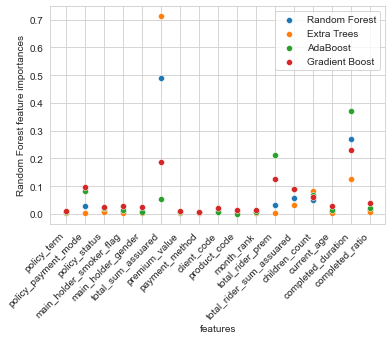

In [120]:
sns.set_style('whitegrid')
ax = sns.scatterplot(x='features',y='Random Forest feature importances',data=feature_dataframe,label='Random Forest')
ax = sns.scatterplot(x='features',y='Extra Trees feature importances',data=feature_dataframe,label='Extra Trees')
ax = sns.scatterplot(x='features',y='AdaBoost feature importances',data=feature_dataframe,label='AdaBoost')
ax = sns.scatterplot(x='features',y='Gradient Boost feature importances',data=feature_dataframe,label='Gradient Boost')
ax.set_xticklabels(
        feature_dataframe['features'],
        rotation=45,
        horizontalalignment='right'
    )


In [121]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,policy_term,0.003260,0.001820,0.007576,0.009321,0.005494
1,policy_payment_mode,0.026602,0.004183,0.083333,0.097355,0.052869
2,policy_status,0.008943,0.006235,0.022727,0.023908,0.015453


In [122]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [123]:
base_predictions_train = pd.DataFrame( 
    {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [124]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [125]:
x_sec_tr = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_sec_ts= np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)
X_sec, X_sec_val, y_sec, y_sec_val = train_test_split(x_sec_tr,y_tr,test_size=0.2, shuffle=True)

In [126]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_sec, y_sec)
y_pred = gbm.predict(X_sec_val)

[20:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [127]:
print(f"Accuracy: {accuracy_score(y_sec_val,y_pred)}")

Accuracy: 0.8760245901639344


In [128]:
y_test_pred = gbm.predict(x_sec_ts)
# submission = pd.Data
#

In [129]:
y_test_pred.shape
x_test.shape

(308, 17)

In [130]:
test_df = x_test.to_dataframe()

AttributeError: 'numpy.ndarray' object has no attribute 'to_dataframe'

In [131]:
test_df['preds'] = y_test_pred

In [134]:
test_df.to_csv(feature_dir+'sub2.csv', index=False)

In [135]:
'''
import json
with open(feature_dir+"mappings.json",'r+') as f0:
    mapping = json.load(f0);

sub_ds =

'''

'\nimport json\nwith open(feature_dir+"mappings.json",\'r+\') as f0:\n    mapping = json.load(f0);\n\nsub_ds =\n\n'